In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn import svm
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,r2_score
import sys
import warnings
import torch
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
sys.path.append('/home/linzenghui/ECG_code/HeartRateVariability_220217')

import FrequencyDomain as fd
import TimeDomain as td
import NonLinear as nl
from common import *
from Rpeaks import *
from preprocess import *

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from sklearn.cross_decomposition import CCA

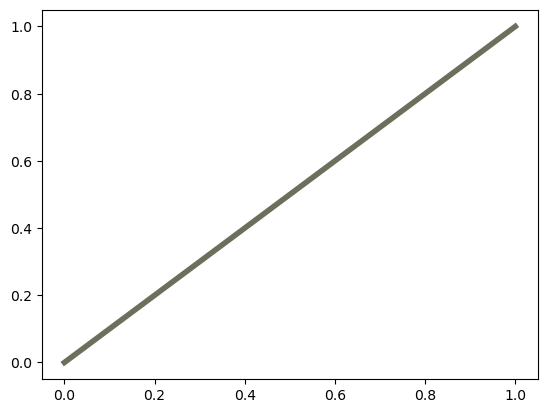

In [56]:
color_para=[(203,153,126),(221,190,169),(253,232,213),(184,183,163),(165,165,141),(107,112,92)]
color_platte=[to_rgba((red/255,green/255,blue/255)) for (red,green,blue) in color_para]
plt.plot([0, 1], [0, 1], color=color_platte[5], linewidth=4)

In [3]:
all_map=['ahi','anno','age','sex/gas','bmi','sdnn', 'sdann_1', 'sdnni_1', 'rmssd', 'sdsd', 'cvnn',
   'cvsd', 'pNN20', 'pNN50', 'tri_index', 'tinn_m', 'tinn_n', 'tinn',
   'vlf_power', 'lf_power', 'hf_power', 'vhf_power', 'total_power', 'lf_n',
   'hf_n', 'lf_hf', 'sd1', 'sd2', 'sd1_sd2', 's', 'csi', 'cvi',
   'csi_modified', 'approximate', 'sample', 'shannon', 'fuzzy', 'cd',
   'hfd', 'kfd', 'lzc']
all_dataset=['wsc','shhs1','shhs2','cfs','numom2b1','numom2b2','msp']
train_dataset=['wsc','shhs1','shhs2','cfs','numom2b1','numom2b2']
test_dataset=['msp']

use_map=['pNN20','pNN50','sdnn','sdann_1','shannon','cvi','sd2','s']
use_dataset=[]

full_map=['sdnn', 'sdann_1', 'sdnni_1', 'rmssd', 'sdsd', 'cvnn',
   'cvsd', 'pNN20', 'pNN50', 'tri_index', 'tinn_m', 'tinn_n', 'tinn',
   'vlf_power', 'lf_power', 'hf_power', 'vhf_power', 'total_power', 'lf_n',
   'hf_n', 'lf_hf', 'sd1', 'sd2', 'sd1_sd2', 's', 'csi', 'cvi',
   'csi_modified', 'approximate', 'sample', 'shannon', 'fuzzy', 'cd',
    'kfd', 'lzc']

In [4]:
##从头计算所有数据集hrv的代码函数块,用于做baseline,但跑完一边后可直接从xlsx里导出来
def make_dataframe(dataset_used, use_control=True,use_norm=True,control_sqi=0.6):
    '''
    return x:ndarray y:ndarray
    '''
    dataset_list=[]
    if 'wsc' in dataset_used:
        dataset_list.append(np.load('/data/0shared/linzenghui/ECG_data/public_dataset/wsc/analysis_extract/wsc.npy'))
        print('wsc loaded down')
    if 'shhs1' in dataset_used:
        dataset_list.append(np.load('/data/0shared/linzenghui/ECG_data/public_dataset/shhs/analysis_extract/shhs1.npy'))
        print('shhs1 loaded down')
    if 'shhs2' in dataset_used:
        dataset_list.append(np.load('/data/0shared/linzenghui/ECG_data/public_dataset/shhs/analysis_extract/shhs2.npy'))
        print('shhs2 loaded down')
    if 'cfs' in dataset_used:
        dataset_list.append(np.load('/data/0shared/linzenghui/ECG_data/public_dataset/cfs/analysis_extract/cfs.npy'))
        print('cfs loaded down')
    if 'numom2b1' in dataset_used:
        dataset_list.append(np.load('/data/0shared/linzenghui/ECG_data/public_dataset/numom2b/analysis_ectract/numom2b1.npy'))
        print('numom2b1 loaded down')
    if 'numom2b2' in dataset_used:
        dataset_list.append(np.load('/data/0shared/linzenghui/ECG_data/public_dataset/numom2b/analysis_ectract/numom2b2.npy'))
        print('numom2b2 loaded down')
    if 'msp' in dataset_used:
        dataset_list.append(np.load('/data/0shared/linzenghui/ECG_data/msp/analysis_extract/msp.npy'))
        print('msp loaded down')
    data_all=np.vstack(dataset_list)
    print(f'all loaded,len{len(data_all)}')
    if use_control:
        print(f'开始质量控制{control_sqi}')
        pass_data=[sqi(data_all[idx,6:],r_peaks(data_all[idx,6:]),control=control_sqi)[0] for idx in range(len(data_all))]
        data_all=data_all[pass_data]
        print('质量控制结束')
    if use_norm:
        print('数据正则化开始')
        data_all=normalize_for_database(data_all)
        print('数据正则化完成')

    dic_list=[]
    print('hrv 计算开始')
    for idx in range(len(data_all)):
        peaks=simple_qrs_detector(data_all[idx,6:],fs=200)
        fineturned_r=R_Wave_finetune(data_all[idx,6:],peaks)
        td_data=td.hrv(fineturned_r,sampling_rate=200).__dict__
        fd_data=fd.frequencies(fineturned_r,200).__dict__
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            poincare_data=nl.poincare(fineturned_r, 200).__dict__
            entropy_data=nl.entropy(fineturned_r, 200).__dict__
        all_dict=dict(**td_data,**fd_data,**poincare_data,**entropy_data)
        all_dict['ahi']=data_all[idx,1]
        all_dict['anno']=data_all[idx,2]
        all_dict['age']=data_all[idx,3]
        all_dict['sex/gas']=data_all[idx,4]
        all_dict['bmi']=data_all[idx,5]
        all_dict['dataset_number']=data_all[idx,0]
        dic_list.append(all_dict)
    print('hrv 计算完毕')
    df_hrv=pd.DataFrame(dic_list)
    return df_hrv

def select_dataset(use_dataset):
    all_df_hrv=pd.read_excel('/data/0shared/linzenghui/ECG_data/public_dataset/hrv_state+msp.xlsx')
    dataset_number_dic={'wsc':6,'shhs1':1,'shhs2':2,'cfs':3,'numom2b1':4,'numom2b2':5,'msp':7}
    use_dataset_number=[dataset_number_dic[name] for name in use_dataset]
    query='dataset_number in '+str(use_dataset_number)
    return all_df_hrv.query(query)

def make_x_y(df_hrv,hrv_state_map,use_ahi):
    x=df_hrv[hrv_state_map]
    if use_ahi:
        y=df_hrv['ahi']
    else:
        y=df_hrv['anno']
    return x,y

In [2]:
##用来计算训练集合测试集的深度特征+age+bmi的代码块+++++++
from net1d import *

class Psg_dataset(Dataset):
    def __init__(self,state,use_cut) :
        if state=='train':
            self.data_all=train_data
            if use_cut:
                self.data_all=cut_data(train_data)
        if state=='test':
            self.data_all=test_data
            if use_cut:
                self.data_all=cut_data(test_data)
    
    def __getitem__(self, index) :
            return self.data_all[index,6:],self.data_all[index,0,1,2,3,5]

    def __len__(self):
        return len(self.data_all)

all_dataset=['wsc','shhs1','shhs2','cfs','numom2b1','numom2b2']
use_dataset=['wsc','shhs1','shhs2','cfs']
train_data,test_data=prepare_data(dataset_used=all_dataset)
train_set=Psg_dataset(state='train',use_cut=True)
test_set=Psg_dataset(state='test',use_cut=True)
train_iter=DataLoader(train_set,batch_size=64,shuffle=False)
test_iter=DataLoader(test_set,batch_size=64,shuffle=False)
print(f'data prepared down.len:{len(test_set)},batch_size:{64}, iter:{len(test_iter)}')

model=Net1D(in_channels=1,base_filters=256,ratio=1,
          filter_list=[256,512,512,256,128,32],m_blocks_list=[3,3,4,4,3,1],
          kernel_size=8,stride=2,
          n_classes=1,use_bn=True,use_do=True,verbose=False,groups_width=16,get_hidden=True)
device_str = torch.device('cuda:3')
model.to(device_str)
model.load_state_dict(torch.load('/data/0shared/linzenghui/ECG_data/public_dataset/ECG_model/model_040',map_location=device_str).state_dict())
print(f'model prepared down. device{device_str}')

model.eval()
train_features=[]
test_features=[]
with torch.no_grad():
    for val_x,val_demo in train_iter:
        val_x=torch.tensor(np.expand_dims(val_x,1)).to(device_str,torch.float32)
        deep_features=model(val_x).to('cpu')
        train_features.append(torch.hstack([val_demo,deep_features]))
    features_train=np.array(torch.vstack(train_features))

    for val_x,val_demo in test_iter:
        val_x=torch.tensor(np.expand_dims(val_x,1)).to(device_str,torch.float32)
        deep_features=model(val_x).to('cpu')
        test_features.append(torch.hstack([val_demo,deep_features]))
    features_test=np.array(torch.vstack(test_features))
print(f'features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep')

features_train[:,4][np.isnan(features_train[:,4])]=np.nanmean(features_train[:,4])
features_test[:,4][np.isnan(features_test[:,4])]=np.nanmean(features_test[:,4])

wsc loaded down
shhs1 loaded down
shhs2 loaded down
cfs loaded down
numom2b1 loaded down
numom2b2 loaded down
开始质量控制0.6
质量控制结束
训练集:7744,测试集2021
数据正则化开始
数据正则化完成
data prepared down.len:20210,batch_size:64, iter:316
model prepared down. devicecuda:3
features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep


In [10]:
#+++++++用来检测深度特征和age+bmi组合效果的代码块，验证集上的++++++++++
model_list=[tree.DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier(),svm.SVC(),LogisticRegression(random_state=0,max_iter=500)]
for model_i in model_list:
    model_i.fit(features_train[:,3:],features_train[:,2])
    y_hat=model_i.predict(features_test[:,3:])
    print(accuracy_score(features_test[:,2],y_hat))

0.6195447798119743
0.6370113805047006
0.643394359228105
0.6381989114299852
0.6410192973775358


In [4]:
##msp深度特征提取
from net1d import *
def prepare_data_test(use_control=True,control_sqi=0.6,use_norm=True):
    data=np.load('/data/0shared/linzenghui/ECG_data/msp/analysis_extract/msp.npy')
    if use_control:
        print(f'开始质量控制{control_sqi}')
        data_pass=[sqi(data[idx,6:],r_peaks(data[idx,6:]),control=control_sqi)[0] for idx in range(len(data))]
        data=data[data_pass]
        print('质量控制结束')
    if use_norm:
        print('数据正则化开始')
        data=normalize_for_database(data)
        print('数据正则化完成')
    return data

def cut_data(data,window_size=30*200,step=30*200,datasetnumber=6):
    database=np.zeros(shape=(int(data.shape[0]*((data.shape[1]-6-window_size)/step+1)),6+window_size))
    database[:,0]=datasetnumber
    count=0
    for idx in range(data.shape[0]):
        for start in range(6,data.shape[1],step):
            database[count,1]=data[idx,1]
            database[count,2]=data[idx,2]
            database[count,3]=data[idx,3]
            database[count,4]=data[idx,4]
            database[count,5]=data[idx,5]
            database[count,6:]=data[idx,start:start+window_size]
            count+=1
    assert count==database.shape[0]
    return database

msp_data=prepare_data_test()

class Psg_dataset_msp(Dataset):
    def __init__(self,use_cut=True) :
        self.data_all=msp_data
        if use_cut:
            self.data_all=cut_data(self.data_all)
    
    def __getitem__(self, index) :
        return self.data_all[index,6:],self.data_all[index,[0,1,2,3,5]]

    def __len__(self):
        return len(self.data_all)

msp_set=Psg_dataset_msp(use_cut=True)
msp_iter=DataLoader(msp_set,batch_size=64,shuffle=False)
print(f'data prepared down.len:,batch_size:{64}, iter:{len(msp_iter)}')

model=Net1D(in_channels=1,base_filters=256,ratio=1,
          filter_list=[256,512,512,256,128,32],m_blocks_list=[3,3,4,4,3,1],
          kernel_size=8,stride=2,
          n_classes=1,use_bn=True,use_do=True,verbose=False,groups_width=16,get_hidden=True)
device_str = torch.device('cuda:3')
model.to(device_str)
model.load_state_dict(torch.load('/data/0shared/linzenghui/ECG_data/public_dataset/ECG_model/model_040',map_location=device_str).state_dict())
print(f'model prepared down. device{device_str}')

model.eval()
msp_features=[]
with torch.no_grad():
    for msp_x,msp_demo in msp_iter:
        train_x=torch.tensor(np.expand_dims(msp_x,1)).to(device_str,torch.float32)
        deep_features=model(train_x).to('cpu')
        msp_features.append(torch.hstack([msp_demo,deep_features]))
    features_msp=np.array(torch.vstack(msp_features))
print(f'msp features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep')

开始质量控制0.6
质量控制结束
数据正则化开始
数据正则化完成
data prepared down.len:,batch_size:64, iter:10
model prepared down. devicecuda:3
msp features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep


In [12]:
##特征逻辑回归的测试结果
for model_i in model_list:
    y_hat=model_i.predict(features_msp[:,3:])
    print(accuracy_score(features_msp[:,2],y_hat))

0.6370967741935484
0.6112903225806452
0.5951612903225807
0.614516129032258
0.5951612903225807


In [5]:
#补做一个在numom2b上调整的结果
from net1d import *

class Psg_dataset(Dataset):
    def __init__(self,state,use_cut) :
        if state=='train':
            self.data_all=train_data
            if use_cut:
                self.data_all=cut_data(train_data)
        if state=='test':
            self.data_all=test_data
            if use_cut:
                self.data_all=cut_data(test_data)
    
    def __getitem__(self, index) :
            return self.data_all[index,6:],self.data_all[index,0:6]

    def __len__(self):
        return len(self.data_all)

use_dataset=['numom2b1','numom2b2']
train_data,test_data=prepare_data(dataset_used=use_dataset)
train_set=Psg_dataset(state='train',use_cut=True)
test_set=Psg_dataset(state='test',use_cut=True)
train_iter=DataLoader(train_set,batch_size=64,shuffle=False)
test_iter=DataLoader(test_set,batch_size=64,shuffle=False)
print(f'data prepared down.len:{len(test_set)},batch_size:{64}, iter:{len(test_iter)}')

model=Net1D(in_channels=1,base_filters=256,ratio=1,
          filter_list=[256,512,512,256,128,32],m_blocks_list=[3,3,4,4,3,1],
          kernel_size=8,stride=2,
          n_classes=1,use_bn=True,use_do=True,verbose=False,groups_width=16,get_hidden=True)
device_str = torch.device('cuda:3')
model.to(device_str)
model.load_state_dict(torch.load('/data/0shared/linzenghui/ECG_data/public_dataset/ECG_model/model_040',map_location=device_str).state_dict())
print(f'model prepared down. device{device_str}')

model.eval()
train_features=[]
test_features=[]
with torch.no_grad():
    for val_x,val_demo in train_iter:
        val_x=torch.tensor(np.expand_dims(val_x,1)).to(device_str,torch.float32)
        deep_features=model(val_x).to('cpu')
        train_features.append(torch.hstack([val_demo,deep_features]))
    features_train=np.array(torch.vstack(train_features))

    for val_x,val_demo in test_iter:
        val_x=torch.tensor(np.expand_dims(val_x,1)).to(device_str,torch.float32)
        deep_features=model(val_x).to('cpu')
        test_features.append(torch.hstack([val_demo,deep_features]))
    features_test=np.array(torch.vstack(test_features))
print(f'features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep')

features_train[:,5][np.isnan(features_train[:,5])]=np.nanmean(features_train[:,5])
features_test[:,5][np.isnan(features_test[:,5])]=np.nanmean(features_test[:,5])

numom2b1 loaded down
numom2b2 loaded down
开始质量控制0.6
质量控制结束
训练集:1551,测试集396
数据正则化开始
数据正则化完成
data prepared down.len:3960,batch_size:64, iter:62
model prepared down. devicecuda:3
features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep


In [41]:
##uamp
import umap
umap_model=umap.UMAP(n_neighbors=10)
umap_result=umap_model.fit_transform(features_test[:,5:])
colors = np.where(features_test[:,2] == 0, 'blue', 'red')
plt.scatter(umap_result[:,0], umap_result[:,1], c=colors,s=1)

/home/linzenghui/anaconda3/envs/ECG_torch/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [4]:
##grad-cam
import gradcam
from gradcam import GradCAM
cam = GradCAM(model=my_net, target_layers=[my_net.stage_list[4]],use_cuda=True)
results = torch.tensor(cam(input_tensor=x)).reshape(2400)

In [15]:
##相关性——hrv解释结果——在msp上——计算预测值+++++
msp_table=select_dataset(['msp'])

from net1d import *
def prepare_data_test(use_control=True,control_sqi=0.6,use_norm=True):
    data=np.load('/data/0shared/linzenghui/ECG_data/msp/analysis_extract/msp.npy')
    if use_control:
        print(f'开始质量控制{control_sqi}')
        data_pass=[sqi(data[idx,6:],r_peaks(data[idx,6:]),control=control_sqi)[0] for idx in range(len(data))]
        data=data[data_pass]
        print('质量控制结束')
    if use_norm:
        print('数据正则化开始')
        data=normalize_for_database(data)
        print('数据正则化完成')
    return data

def cut_data(data,window_size=30*200,step=30*200,datasetnumber=6):
    database=np.zeros(shape=(int(data.shape[0]*((data.shape[1]-6-window_size)/step+1)),6+window_size))
    database[:,0]=datasetnumber
    count=0
    for idx in range(data.shape[0]):
        for start in range(6,data.shape[1],step):
            database[count,1]=data[idx,1]
            database[count,2]=data[idx,2]
            database[count,3]=data[idx,3]
            database[count,4]=data[idx,4]
            database[count,5]=data[idx,5]
            database[count,6:]=data[idx,start:start+window_size]
            count+=1
    assert count==database.shape[0]
    return database

msp_data=prepare_data_test()

class Psg_dataset_msp(Dataset):
    def __init__(self,use_cut=True) :
        self.data_all=msp_data
        if use_cut:
            self.data_all=cut_data(self.data_all)
    
    def __getitem__(self, index) :
        return self.data_all[index,6:],self.data_all[index,[0,1,2,3,5]]

    def __len__(self):
        return len(self.data_all)

msp_set=Psg_dataset_msp(use_cut=True)
msp_iter=DataLoader(msp_set,batch_size=10,shuffle=False)
print(f'data prepared down.len:,batch_size:{10}, iter:{len(msp_iter)}')

model=Net1D(in_channels=1,base_filters=256,ratio=1,
          filter_list=[256,512,512,256,128,32],m_blocks_list=[3,3,4,4,3,1],
          kernel_size=8,stride=2,
          n_classes=1,use_bn=True,use_do=True,verbose=False,groups_width=16,get_hidden=False)
device_str = torch.device('cuda:3')
model.to(device_str)
model.load_state_dict(torch.load('/data/0shared/linzenghui/ECG_data/public_dataset/ECG_model/model_040',map_location=device_str).state_dict())
print(f'model prepared down. device{device_str}')

model.eval()
y_pre=torch.tensor([])
with torch.no_grad():
    for msp_x,msp_demo in msp_iter:
        train_x=torch.tensor(np.expand_dims(msp_x,1)).to(device_str,torch.float32)
        y_hat=torch.sigmoid(model(train_x).to('cpu'))
        y_pre=torch.cat((y_pre,y_hat))
avg_pre=np.array(y_pre.reshape(62,10)).mean(-1)
print(f'msp features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep')

开始质量控制0.6
质量控制结束
数据正则化开始
数据正则化完成
data prepared down.len:,batch_size:10, iter:62
model prepared down. devicecuda:3
msp features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep


In [9]:
#+++++++msp上解释性结果大概在-0.6
x_train,x_test,y_train,y_test=train_test_split(table[use_hrv],avg_pre,test_size=0.3)
clf=LinearRegression().fit(x_train,y_train)
r2_score(y_train,clf.predict(x_train))

NameError: name 'table' is not defined

In [42]:
##用来计算测试集HRV的代码块
from net1d import *

class Psg_tail_dataset(Dataset):
    def __init__(self,state) :
        if state=='train':
            self.data_all=train_data
        if state=='test':
            self.data_all=test_data
    
    def __getitem__(self, index) :
            return self.data_all[index],self.data_all[index,2]

    def __len__(self):
        return len(self.data_all)

all_dataset=['wsc','shhs1','shhs2','cfs','numom2b1','numom2b2']
train_data,test_data=prepare_data(dataset_used=all_dataset)

train_set=Psg_tail_dataset(state='train')
# test_set=Psg_tail_dataset(state='test')
train_iter=DataLoader(train_set,batch_size=64,shuffle=False)
# test_iter=DataLoader(test_set,batch_size=64,shuffle=False)
print(f'data prepared down.len:{len(train_set)},batch_size:{64}, iter:{len(train_iter)}')

model=Net1D(in_channels=1,base_filters=256,ratio=1,
          filter_list=[256,512,512,256,128,32],m_blocks_list=[3,3,4,4,3,1],
          kernel_size=8,stride=2,
          n_classes=1,use_bn=True,use_do=True,verbose=False,groups_width=16,get_hidden=False)
device_str = torch.device('cuda:3')
model.to(device_str)
model.load_state_dict(torch.load('/data/0shared/linzenghui/ECG_data/public_dataset/ECG_model/model_040',map_location=device_str).state_dict())
print(f'model prepared down. device{device_str}')

model.eval()
y_pre=torch.tensor([])
with torch.no_grad():
    for val_x,val_demo in test_iter:
        val_x=torch.tensor(np.expand_dims(val_x[:,-6000:],1)).to(device_str,torch.float32)
        y_hat=torch.sigmoid(model(val_x).to('cpu'))
        y_pre=torch.cat((y_pre,y_hat))

wsc loaded down
shhs1 loaded down
shhs2 loaded down
cfs loaded down
numom2b1 loaded down
numom2b2 loaded down
开始质量控制0.6
质量控制结束
训练集:7744,测试集2021
数据正则化开始
数据正则化完成
data prepared down.len:2021,batch_size:64, iter:32
model prepared down. devicecuda:3


In [43]:
with open('/data/0shared/linzenghui/ECG_data/public_dataset/prepared_test_data.npy','xb') as f:
    np.save(f,test_data)
with open('/data/0shared/linzenghui/ECG_data/public_dataset/prepared_train_data.npy','xb') as f:
    np.save(f,train_data)

In [3]:
train_data=np.load('/data/0shared/linzenghui/ECG_data/public_dataset/prepared_train_data.npy')

In [5]:
dic_list=[]
print('hrv 计算开始')
for idx in range(len(train_data)):
    peaks=simple_qrs_detector(train_data[idx,6:],fs=200)
    fineturned_r=R_Wave_finetune(train_data[idx,6:],peaks)
    td_data=td.hrv(fineturned_r,sampling_rate=200).__dict__
    fd_data=fd.frequencies(fineturned_r,200).__dict__
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        poincare_data=nl.poincare(fineturned_r, 200).__dict__
        entropy_data=nl.entropy(fineturned_r, 200).__dict__
    all_dict=dict(**td_data,**fd_data,**poincare_data,**entropy_data)
    all_dict['ahi']=train_data[idx,1]
    all_dict['anno']=train_data[idx,2]
    all_dict['age']=train_data[idx,3]
    all_dict['sex/gas']=train_data[idx,4]
    all_dict['bmi']=train_data[idx,5]
    all_dict['dataset_number']=train_data[idx,0]
    all_dict['idx']=idx
    dic_list.append(all_dict)
print('hrv 计算完毕')
df_hrv=pd.DataFrame(dic_list)

hrv 计算开始
hrv 计算完毕


In [6]:
df_hrv.to_excel('train_hrv.xlsx')

In [48]:
df_hrv[use_hrv]

,sdnn,sdann_1,pNN20,pNN50,sd2,s,cvi,shannon
0,51.722946,8.577603,31.250000,5.059524,67.303432,6107.232603,4.492815,4.724929
1,60.388003,14.665697,28.358209,0.895522,81.255402,6778.997646,4.538136,5.079074
2,42.141152,18.901185,31.481481,1.481481,52.174062,3440.905262,4.243643,4.552857
3,75.815220,13.155879,48.742138,11.320755,89.026770,16782.212061,4.931819,5.339863
4,71.435703,40.565007,17.575758,2.121212,87.080552,13178.060601,4.826822,5.084620
...,...,...,...,...,...,...,...,...
2016,35.512916,18.249013,4.494382,1.498127,42.507955,3577.722100,4.260577,4.335976
2017,75.726647,21.381836,34.647887,5.352113,92.582575,15415.397141,4.894925,4.492403
2018,72.217089,30.894329,19.718310,5.399061,83.399946,15491.119676,4.897053,5.301759
2019,37.334428,15.086846,47.588424,8.360129,48.270869,3267.832078,4.221230,4.772070


In [50]:
x_train,x_test,y_train,y_test=train_test_split(df_hrv[use_hrv],y_pre,test_size=0.3)
clf=LinearRegression().fit(x_train,y_train)
r2_score(y_test,clf.predict(x_test))

0.045962150746690855

In [18]:
def cal_deep_features(data,device_str):

    class Psg_dataset_iner(Dataset):
        def __init__(self,use_cut=True) :
            self.data_all=data
            if use_cut:
                self.data_all=cut_data(self.data_all)
        
        def __getitem__(self, index) :
            return self.data_all[index,6:],self.data_all[index,0:6]

        def __len__(self):
            return len(self.data_all)
        
    temp_set=Psg_dataset_iner(use_cut=True)
    temp_iter=DataLoader(temp_set,batch_size=64,shuffle=False)
    print(f'data prepared down.len:,batch_size:{64}, iter:{len(temp_iter)}')

    model=Net1D(in_channels=1,base_filters=256,ratio=1,
          filter_list=[256,512,512,256,128,32],m_blocks_list=[3,3,4,4,3,1],
          kernel_size=8,stride=2,
          n_classes=1,use_bn=True,use_do=True,verbose=False,groups_width=16,get_hidden=True)
    model.to(device_str)
    model.load_state_dict(torch.load('/data/0shared/linzenghui/ECG_data/public_dataset/ECG_model/model_040',map_location=device_str).state_dict())
    print(f'model prepared down. device{device_str}')

    model.eval()
    temp_features=[]
    with torch.no_grad():
        for temp_x,temp_demo in temp_iter:
            train_x=torch.tensor(np.expand_dims(temp_x,1)).to(device_str,torch.float32)
            deep_features=model(train_x).to('cpu')
            temp_features.append(torch.hstack([temp_demo,deep_features]))
        features_temp=np.array(torch.vstack(temp_features))
    print(f'deep features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep')
    return features_temp

def hrv_expand(hrv_array):
    new_array=np.empty(shape=(10*hrv_array.shape[0],hrv_array.shape[1]))
    count=0
    for idx in range(hrv_array.shape[0]):
        for i in range(10):
            new_array[count,:]=hrv_array[idx,:]
            count+=1
    return new_array

In [4]:
test_data=np.load('/data/0shared/linzenghui/ECG_data/public_dataset/prepared_test_data.npy')

In [6]:
test_dp=cal_deep_features(test_data,torch.device('cuda:3'))

data prepared down.len:,batch_size:64, iter:316
model prepared down. devicecuda:3
deep features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep


In [122]:
test_hrv=pd.read_excel('./test_hrv.xlsx')

In [123]:
test_hrv=hrv_expand(np.array(test_hrv[full_map]))

In [124]:
cca = CCA(n_components=32)
cca.fit(test_dp[:,6:],test_hrv)
X_c, Y_c = cca.transform(test_dp[:,6:],test_hrv)

<BarContainer object of 32 artists>

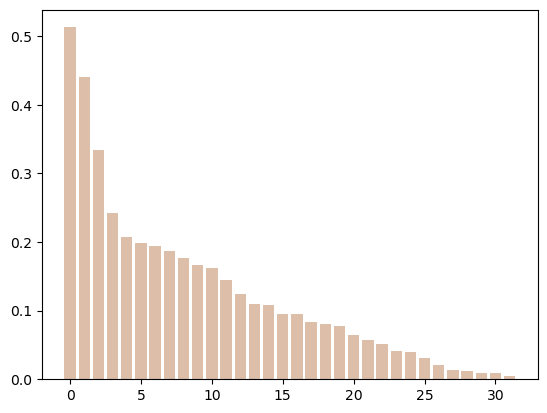

In [127]:
canonical_correlations = np.corrcoef(X_c.T, Y_c.T)[:32, 32:]
diagonal_elements = np.diagonal(canonical_correlations)
plt.bar(np.arange(32),diagonal_elements,color=color_platte[1])

[[1.         0.51294079]
 [0.51294079 1.        ]]


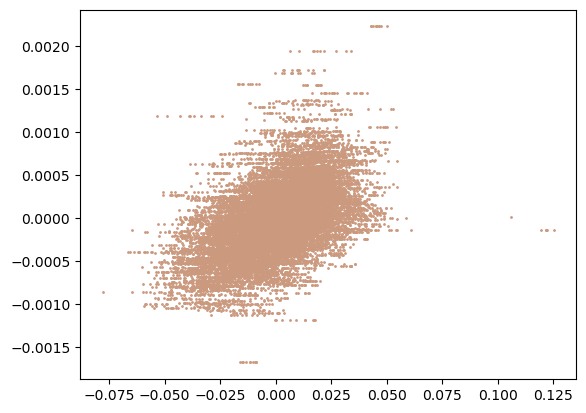

In [129]:
print(np.corrcoef(X_c[:,0],Y_c[:,0]))
plt.scatter(X_c[:,0],Y_c[:,0],color=color_platte[0],s=1)

In [137]:
##补做dp+hrv
test_dif=np.hstack((test_dp,test_hrv))
clf=LogisticRegression(max_iter=1000)
x_train,x_test,y_train,y_test=train_test_split(test_dif[:,6:],test_dif[:,2],test_size=0.3)
clf.fit(x_train,y_train)
accuracy_score(y_test,clf.predict(x_test))

/home/linzenghui/anaconda3/envs/ECG_torch/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6678212106218044

In [5]:
##这是在康迪上的检测效果,效果很差
from net1d import *
def prepare_data_test(use_control=True,control_sqi=0.6,use_norm=True):
    data=np.load('/data/0shared/linzenghui/ECG_data/msp/analysis_extract/msp.npy')
    if use_control:
        print(f'开始质量控制{control_sqi}')
        data_pass=[sqi(data[idx,6:],r_peaks(data[idx,6:]),control=control_sqi)[0] for idx in range(len(data))]
        data=data[data_pass]
        print('质量控制结束')
    if use_norm:
        print('数据正则化开始')
        data=normalize_for_database(data)
        print('数据正则化完成')
    return data


def cut_data(data,window_size=30*200,step=30*200,datasetnumber=6):
    database=np.zeros(shape=(int(data.shape[0]*((data.shape[1]-6-window_size)/step+1)),6+window_size))
    database[:,0]=datasetnumber
    count=0
    for idx in range(data.shape[0]):
        for start in range(6,data.shape[1],step):
            database[count,1]=data[idx,1]
            database[count,2]=data[idx,2]
            database[count,3]=data[idx,3]
            database[count,4]=data[idx,4]
            database[count,5]=data[idx,5]
            database[count,6:]=data[idx,start:start+window_size]
            count+=1
    assert count==database.shape[0]
    return database

class Psg_dataset_test(Dataset):
    def __init__(self,use_cut,mode) :
        self.data_all=msp_data
        self.train_data,self.test_data=train_test_split(msp_data,test_size=0.3)
        if use_cut:
            self.train_data=cut_data(self.train_data)
            self.test_data=cut_data(self.test_data)
        self.mode=mode
    
    def __getitem__(self, index) :
        if self.mode=='train':
            return self.train_data[index,6:],self.train_data[index,0:6]
        if self.mode=='test':
            return self.test_data[index,6:],self.test_data[index,0:6]
        if self.mode=='all':
            return self.data_all[index,6:],self.data_all[index,0:6]

    def __len__(self):
        if self.mode=='train':
            return len(self.train_data)
        if self.mode=='test':
            return len(self.test_data)
        if self.mode=='all':
            return len(self.data_all)

msp_data=prepare_data_test()
train_msp_set=Psg_dataset_test(use_cut=True,mode='train')
test_msp_set=Psg_dataset_test(use_cut=True,mode='test')
train_iter=DataLoader(train_msp_set,batch_size=64,shuffle=False)
test_iter=DataLoader(test_msp_set,batch_size=64,shuffle=False)
print(f'data prepared down.len:,batch_size:{64}, iter:{len(test_iter)}')

model=Net1D(in_channels=1,base_filters=256,ratio=1,
          filter_list=[256,512,512,256,128,32],m_blocks_list=[3,3,4,4,3,1],
          kernel_size=8,stride=2,
          n_classes=1,use_bn=True,use_do=True,verbose=False,groups_width=16,get_hidden=True)
device_str = torch.device('cuda:3')
model.to(device_str)
model.load_state_dict(torch.load('/data/0shared/linzenghui/ECG_data/public_dataset/ECG_model/model_040',map_location=device_str).state_dict())
print(f'model prepared down. device{device_str}')

model.eval()
train_features=[]
with torch.no_grad():
    for train_x,train_demo in train_iter:
        train_x=torch.tensor(np.expand_dims(train_x,1)).to(device_str,torch.float32)
        deep_features=model(train_x).to('cpu')
        train_features.append(torch.hstack([train_demo,deep_features]))
    features_train=np.array(torch.vstack(train_features))
print(f'train features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep')

model.eval()
test_features=[]
with torch.no_grad():
    for test_x,test_demo in test_iter:
        test_x=torch.tensor(np.expand_dims(test_x,1)).to(device_str,torch.float32)
        deep_features=model(test_x).to('cpu')
        test_features.append(torch.hstack([test_demo,deep_features]))
    features_test=np.array(torch.vstack(test_features))
print(f'test features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep')

model_list=[tree.DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier(),svm.SVC(),LogisticRegression(random_state=0,max_iter=1000)]

for model_x in model_list:
    model_x.fit(features_train[:,3:],features_train[:,2])
    print(accuracy_score(features_test[:,2],model_x.predict(features_test[:,3:])))

class psg_kangdi_dataset(Dataset):
    def __init__(self,use_cut) :
        self.data_all=normalize_for_database(np.load('/data/0shared/linzenghui/ECG_data/康迪/filtered_kangdi.npy'))
        if use_cut:
            self.data_all=cut_data(self.data_all)
    
    def __getitem__(self, index) :
            return self.data_all[index,6:],self.data_all[index,0:6]

    def __len__(self):
        return len(self.data_all)
    
kangdi_set=psg_kangdi_dataset(use_cut=True)
outer_test_iter=DataLoader(kangdi_set,batch_size=64,shuffle=False)

model.eval()
outer_test_features=[]
with torch.no_grad():
    for test_x,test_demo in outer_test_iter:
        test_x=torch.tensor(np.expand_dims(test_x,1)).to(device_str,torch.float32)
        deep_features=model(test_x).to('cpu')
        outer_test_features.append(torch.hstack([test_demo,deep_features]))
    outer_features_test=np.array(torch.vstack(outer_test_features))
print(f'kangdi features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep')
for model_x in model_list:
    print(accuracy_score(outer_features_test[:,2],model_x.predict(outer_features_test[:,3:])))

开始质量控制0.6
质量控制结束
数据正则化开始
数据正则化完成
data prepared down.len:,batch_size:64, iter:3
model prepared down. devicecuda:3
train features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep
test features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep
0.8947368421052632
0.8947368421052632
0.9052631578947369
0.8631578947368421
0.8947368421052632
kangdi features extracted down. datasetnumber+ahi+0/1+age+sex+bmi+32deep
0.5516129032258065
0.5709677419354838
0.55
0.5709677419354838
0.5951612903225807


In [16]:
train_data,test_data=train_test_split(msp_data,test_size=0.2)

In [13]:
clf=LogisticRegression(random_state=0,max_iter=1000).fit(train_x,train_y)

In [144]:
def classify(x,y):
    normal_x_number=[y_i==0 for y_i in y]
    abnormal_x_number=[y_i==1 for y_i in y]
    return x[normal_x_number].to_numpy().reshape(-1),x[abnormal_x_number].to_numpy().reshape(-1)

def distribution_hrv(hrv_state):
    hrv_tuple=[classify(*make_x_y(select_dataset([name]),hrv_state_map=[hrv_state],use_ahi=False)) for name in all_dataset]
    hrv_list=[]
    for single_tuple in hrv_tuple:
        normal_x,abnormal_x=single_tuple
        hrv_list.append(normal_x)
        hrv_list.append(abnormal_x)
    return hrv_list

labels=['wsc_0','wsc_1','shhs1_0','shhs1_1','shhs2_0','shhs2_1','cfs_0','cfs_1','numom2b1_0','numom2b1_1','numom2b2_0','numom2b2_1','msp_0','msp_1']

In [155]:
from scipy.stats import mannwhitneyu
p_value={}
for idx, hrv_state in enumerate(all_map):
    normal,abnormal=classify(*make_x_y(select_dataset(['msp']),hrv_state_map=[hrv_state],use_ahi=False))
    p_value[hrv_state]=mannwhitneyu(normal,abnormal).pvalue

In [158]:
pd.DataFrame([p_value]).to_excel('msp.xlsx')

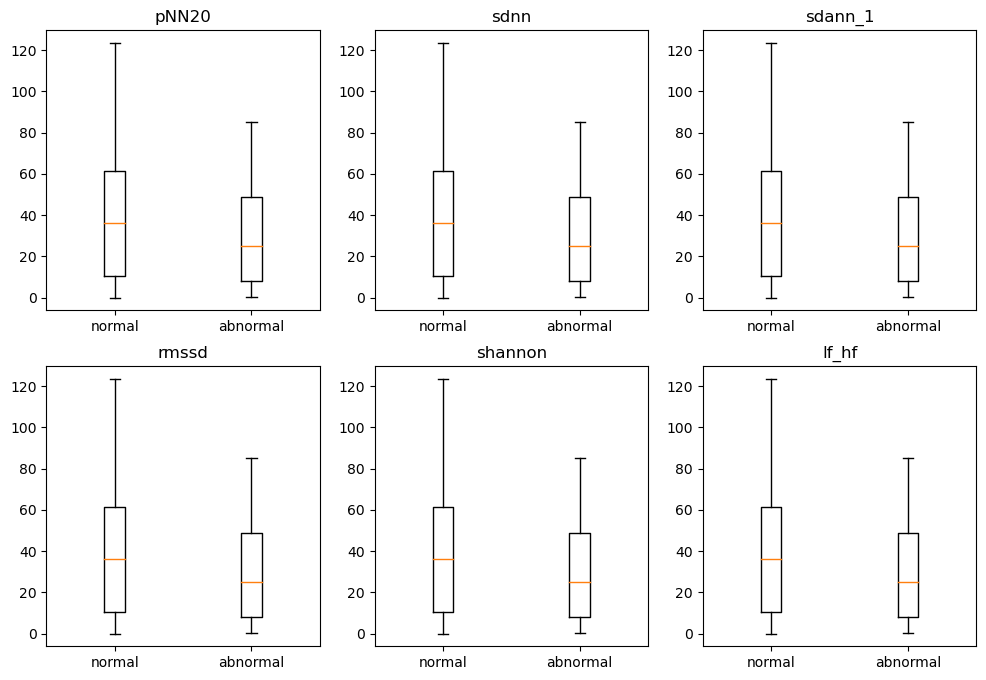

In [12]:
fig,ax=plt.subplots(nrows=2,ncols=3)
fig.set_size_inches((12,8))
ax=ax.flatten()
for idx, hrv_state in enumerate(use_map):
    normal,abnormal=classify(*make_x_y(df_hrv=df_hrv,hrv_state_map=use_map,use_ahi=False))
    ax[idx].boxplot([normal,abnormal],labels=['normal','abnormal'],showfliers=False)
    ax[idx].set_title(hrv_state)

In [143]:
normal,abnormal=classify(*make_x_y(select_dataset(['numom2b1']),hrv_state_map=use_map,use_ahi=False))

NameError: name 'classify' is not defined

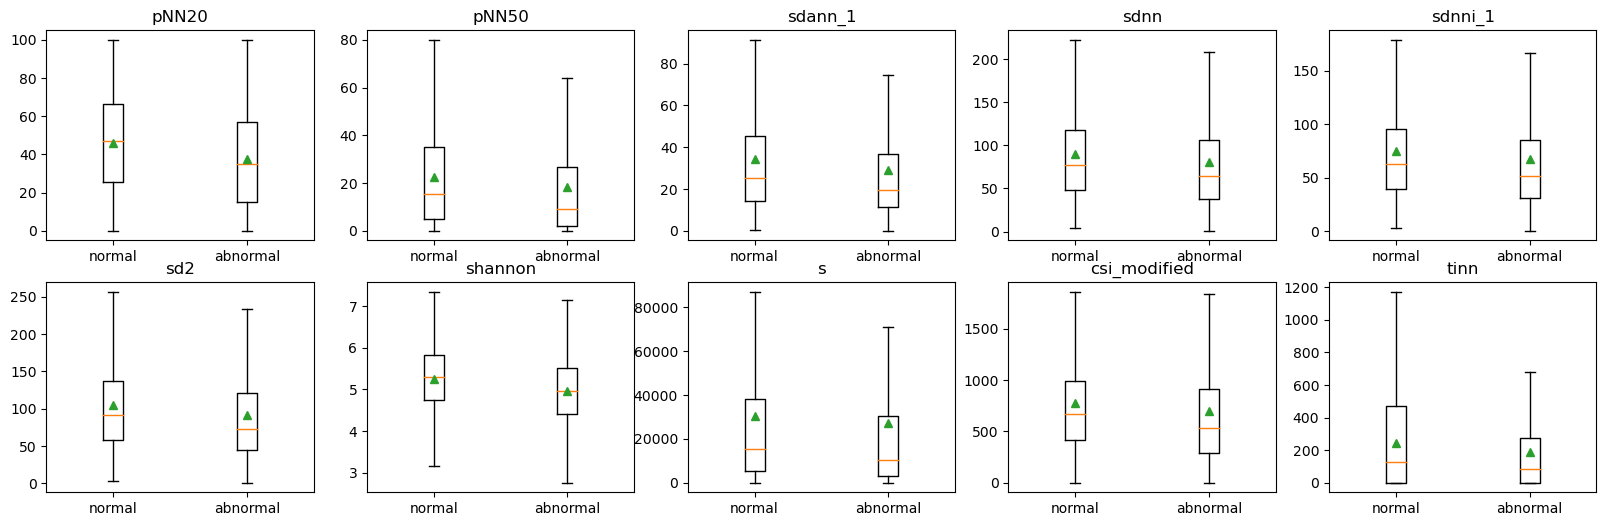

In [40]:
fig,ax=plt.subplots(nrows=2,ncols=5)
fig.set_size_inches((20,6))
ax=ax.flatten()
hrv_list=['pNN20','pNN50','sdann_1','sdnn','sdnni_1','sd2','shannon','s','csi_modified','tinn']
for idx, hrv_state in enumerate(hrv_list):
    normal,abnormal=classify(*make_x_y(select_dataset(all_dataset),hrv_state_map=[hrv_state],use_ahi=False))
    ax[idx].boxplot([normal,abnormal],labels=['normal','abnormal'],showmeans=True,showfliers=False)
    ax[idx].set_title(hrv_state)

Text(0.5, 1.0, 'shannon')

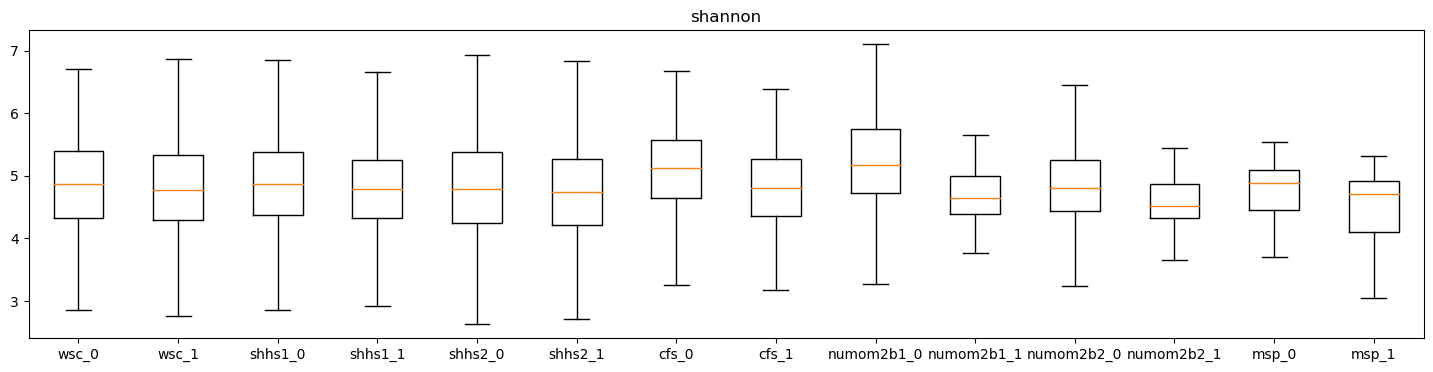

In [23]:
hrv_str='shannon'
plt.figure(figsize=(18,4))
plt.boxplot(distribution_hrv(hrv_str),labels=labels,showfliers=False)
plt.title(hrv_str)

In [26]:
x,y=make_x_y(select_dataset(train_dataset),hrv_state_map=use_map,use_ahi=False)

In [10]:
x['bmi']=x['bmi'].fillna(np.nanmean(np.array(x['bmi']).reshape(-1)))

In [6]:
x,y=make_x_y(df_hrv,hrv_state_map=use_map,use_ahi=False)

In [8]:
use_map

['pNN20', 'sdnn', 'sdann_1', 'rmssd', 'shannon', 'lf_hf']

In [27]:
kfold=KFold(n_splits=10,shuffle=True)
model_list=[tree.DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier(),svm.SVC()]
for model in model_list:
    print(cross_val_score(estimator=model,X=x,y=y,cv=kfold).mean())

0.5349694615500781
0.5701980594660805
0.5677437622699129
0.5559667432924476


In [68]:
train_x,test_x,train_y,test_y=train_test_split(x,y)

In [69]:
kfold=KFold(n_splits=10,shuffle=True)
clf=tree.DecisionTreeClassifier()
cross_val_score(estimator=clf,X=x,y=y,cv=kfold).mean()

0.5094465117801762

In [70]:
clf=RandomForestClassifier(n_estimators=100)
cross_val_score(estimator=clf,X=x,y=y,cv=kfold).mean()

0.5098479144159382

In [71]:
bst=XGBClassifier()
cross_val_score(bst,x,y,cv=kfold,scoring='roc_auc').mean()

0.5244068755266256

In [76]:
model=svm.SVC()
cross_val_score(model,x,y,cv=kfold,scoring='roc_auc').mean()

0.6084047491158537